## NLP OOD Detection with Score-Based Generative Models

### Score and Score-Based Models
Given a probablity density function $p(\mathbf{x})$, we define the *score* as $$\nabla_\mathbf{x} \log p(\mathbf{x}).$$ As you might guess, score-based generative models are trained to estimate $\nabla_\mathbf{x} \log p(\mathbf{x})$. Unlike likelihood-based models such as flow models or autoregressive models, score-based models do not have to be normalized and are easier to parameterize. For example, consider a non-normalized statistical model $p_\theta(\mathbf{x}) = \frac{e^{-E_\theta(\mathbf{x})}}{Z_\theta}$, where $E_\theta(\mathbf{x}) \in \mathbb{R}$ is called the energy function and $Z_\theta$ is an unknown normalizing constant that makes $p_\theta(\mathbf{x})$ a proper probability density function. The energy function is typically parameterized by a flexible neural network. When training it as a likelihood model, we need to know the normalizing constant $Z_\theta$ by computing complex high-dimensional integrals, which is typically intractable. In constrast, when computing its score, we obtain $\nabla_\mathbf{x} \log p_\theta(\mathbf{x}) = -\nabla_\mathbf{x} E_\theta(\mathbf{x})$ which does not require computing the normalizing constant $Z_\theta$.

In fact, any neural network that maps an input vector $\mathbf{x} \in \mathbb{R}^d$ to an output vector $\mathbf{y} \in \mathbb{R}^d$ can be used as a score-based model, as long as the output and input have the same dimensionality. This yields huge flexibility in choosing model architectures.

### Perturbing Data with a Diffusion Process

In order to generate samples with score-based models, we need to consider a [diffusion process](https://en.wikipedia.org/wiki/Diffusion_process) that corrupts data slowly into random noise. Scores will arise when we reverse this diffusion process for sample generation. You will see this later in the notebook.

A diffusion process is a [stochastic process](https://en.wikipedia.org/wiki/Stochastic_process#:~:text=A%20stochastic%20or%20random%20process%20can%20be%20defined%20as%20a,an%20element%20in%20the%20set.) similar to [Brownian motion](https://en.wikipedia.org/wiki/Brownian_motion). Their paths are like the trajectory of a particle submerged in a flowing fluid, which moves randomly due to unpredictable collisions with other particles. Let $\{\mathbf{x}(t) \in \mathbb{R}^d \}_{t=0}^T$ be a diffusion process, indexed by the continuous time variable $t\in [0,T]$. A diffusion process is governed by a stochastic differential equation (SDE), in the following form

\begin{align*}
d \mathbf{x} = \mathbf{f}(\mathbf{x}, t) d t + g(t) d \mathbf{w},
\end{align*}

where $\mathbf{f}(\cdot, t): \mathbb{R}^d \to \mathbb{R}^d$ is called the *drift coefficient* of the SDE, $g(t) \in \mathbb{R}$ is called the *diffusion coefficient*, and $\mathbf{w}$ represents the standard Brownian motion. You can understand an SDE as a stochastic generalization to ordinary differential equations (ODEs). Particles moving according to an SDE not only follows the deterministic drift $\mathbf{f}(\mathbf{x}, t)$, but are also affected by the random noise coming from $g(t) d\mathbf{w}$. From now on, we use $p_t(\mathbf{x})$ to denote the distribution of $\mathbf{x}(t)$.

For score-based generative modeling, we will choose a diffusion process such that $\mathbf{x}(0) \sim p_0$, and $\mathbf{x}(T) \sim p_T$. Here $p_0$ is the data distribution where we have a dataset of i.i.d. samples, and $p_T$ is the prior distribution that has a tractable form and easy to sample from. The noise perturbation by the diffusion process is large enough to ensure $p_T$ does not depend on $p_0$.

### Reversing the Diffusion Process Yields Score-Based Generative Models
By starting from a sample from the prior distribution $p_T$ and reversing the diffusion process, we will be able to obtain a sample from the data distribution $p_0$. Crucially, the reverse process is a diffusion process running backwards in time. It is given by the following reverse-time SDE

\begin{align}
  d\mathbf{x} = [\mathbf{f}(\mathbf{x}, t) - g^2(t)\nabla_{\mathbf{x}}\log p_t(\mathbf{x})] dt + g(t) d\bar{\mathbf{w}},
\end{align}

where $\bar{\mathbf{w}}$ is a Brownian motion in the reverse time direction, and $dt$ represents an infinitesimal negative time step. This reverse SDE can be computed once we know the drift and diffusion coefficients of the forward SDE, as well as the score of $p_t(\mathbf{x})$ for each $t\in[0, T]$.

The overall intuition of score-based generative modeling with SDEs can be summarized in the illustration below

![sde schematic](https://drive.google.com/uc?id=1Ptvb790eQRYMHLnDGBeYZK9A2cF-JMEP)


### Score Estimation

Based on the above intuition, we can use the time-dependent score function $\nabla_\mathbf{x} \log p_t(\mathbf{x})$ to construct the reverse-time SDE, and then solve it numerically to obtain samples from $p_0$ using samples from a prior distribution $p_T$. We can train a time-dependent score-based model $s_\theta(\mathbf{x}, t)$ to approximate $\nabla_\mathbf{x} \log p_t(\mathbf{x})$, using the following weighted sum of [denoising score matching](http://www.iro.umontreal.ca/~vincentp/Publications/smdae_techreport.pdf) objectives.

\begin{align}
\min_\theta \mathbb{E}_{t\sim \mathcal{U}(0, T)} [\lambda(t) \mathbb{E}_{\mathbf{x}(0) \sim p_0(\mathbf{x})}\mathbf{E}_{\mathbf{x}(t) \sim p_{0t}(\mathbf{x}(t) \mid \mathbf{x}(0))}[ \|s_\theta(\mathbf{x}(t), t) - \nabla_{\mathbf{x}(t)}\log p_{0t}(\mathbf{x}(t) \mid \mathbf{x}(0))\|_2^2]],
\end{align}
where $\mathcal{U}(0,T)$ is a uniform distribution over $[0, T]$, $p_{0t}(\mathbf{x}(t) \mid \mathbf{x}(0))$ denotes the transition probability from $\mathbf{x}(0)$ to $\mathbf{x}(t)$, and $\lambda(t) \in \mathbb{R}_{>0}$ denotes a positive weighting function.

In the objective, the expectation over $\mathbf{x}(0)$ can be estimated with empirical means over data samples from $p_0$. The expectation over $\mathbf{x}(t)$ can be estimated by sampling from $p_{0t}(\mathbf{x}(t) \mid \mathbf{x}(0))$, which is efficient when the drift coefficient $\mathbf{f}(\mathbf{x}, t)$ is affine. The weight function $\lambda(t)$ is typically chosen to be inverse proportional to $\mathbb{E}[\|\nabla_{\mathbf{x}}\log p_{0t}(\mathbf{x}(t) \mid \mathbf{x}(0)) \|_2^2]$.



### Time-Dependent Score-Based Model

There are no restrictions on the network architecture of time-dependent score-based models, except that their output should have the same dimensionality as the input, and they should be conditioned on time.

Several useful tips on architecture choice:
* It usually performs well to use the [U-net](https://arxiv.org/abs/1505.04597) architecture as the backbone of the score network $s_\theta(\mathbf{x}, t)$,

* We can incorporate the time information via [Gaussian random features](https://arxiv.org/abs/2006.10739). Specifically, we first sample $\omega \sim \mathcal{N}(\mathbf{0}, s^2\mathbf{I})$ which is subsequently fixed for the model (i.e., not learnable). For a time step $t$, the corresponding Gaussian random feature is defined as
\begin{align}
  [\sin(2\pi \omega t) ; \cos(2\pi \omega t)],
\end{align}
where $[\vec{a} ; \vec{b}]$ denotes the concatenation of vector $\vec{a}$ and $\vec{b}$. This Gaussian random feature can be used as an encoding for time step $t$ so that the score network can condition on $t$ by incorporating this encoding. We will see this further in the code.

* We can rescale the output of the U-net by $1/\sqrt{\mathbb{E}[\|\nabla_{\mathbf{x}}\log p_{0t}(\mathbf{x}(t) \mid \mathbf{x}(0)) \|_2^2]}$. This is because the optimal $s_\theta(\mathbf{x}(t), t)$ has an $\ell_2$-norm close to $\mathbb{E}[\|\nabla_{\mathbf{x}}\log p_{0t}(\mathbf{x}(t) \mid \mathbf{x}(0))]\|_2$, and the rescaling helps capture the norm of the true score. Recall that the training objective contains sums of the form
\begin{align*}
\mathbf{E}_{\mathbf{x}(t) \sim p_{0t}(\mathbf{x}(t) \mid \mathbf{x}(0))}[ \|s_\theta(\mathbf{x}(t), t) - \nabla_{\mathbf{x}(t)}\log p_{0t}(\mathbf{x}(t) \mid \mathbf{x}(0))\|_2^2].
\end{align*}
Therefore, it is natural to expect that the optimal score model $s_\theta(\mathbf{x}, t) \approx \nabla_{\mathbf{x}(t)} \log p_{0t}(\mathbf{x}(t) \mid \mathbf{x}(0))$.

* Use [exponential moving average](https://discuss.pytorch.org/t/how-to-apply-exponential-moving-average-decay-for-variables/10856/3) (EMA) of weights when sampling. This can greatly improve sample quality, but requires slightly longer training time, and requires more work in implementation. We do not include this in this tutorial, but highly recommend it when you employ score-based generative modeling to tackle more challenging real problems.

In [1]:
import functools
import pathlib
import torch
import torch.nn as nn
import project.utils as utils
import project.train as train
import matplotlib.pyplot as plt
import pandas as pd
from transformers import AutoTokenizer, CLIPTextModel, AutoModel, CLIPModel
from torch.utils.data import DataLoader
from sklearn.model_selection import train_test_split
from functools import partial

from project.simple_mlp import SimpleMLP

%load_ext autoreload
%autoreload 2

2024-04-17 11:17:22.102499: I tensorflow/core/util/port.cc:113] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2024-04-17 11:17:22.105912: I external/local_tsl/tsl/cuda/cudart_stub.cc:32] Could not find cuda drivers on your machine, GPU will not be used.
2024-04-17 11:17:22.143985: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 AVX512F AVX512_VNNI FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2024-04-17 11:17:23.144840: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


## Training with Weighted Sum of Denoising Score Matching Objectives

Now let's get our hands dirty on training. First of all, we need to specify an SDE that perturbs the data distribution $p_0$ to a prior distribution $p_T$. We choose the following SDE
\begin{align*}
d \mathbf{x} = \sigma^t d\mathbf{w}, \quad t\in[0,1]
\end{align*}
In this case,
\begin{align*}
p_{0t}(\mathbf{x}(t) \mid \mathbf{x}(0)) = \mathcal{N}\bigg(\mathbf{x}(t); \mathbf{x}(0), \frac{1}{2\log \sigma}(\sigma^{2t} - 1) \mathbf{I}\bigg)
\end{align*}
and we can choose the weighting function $\lambda(t) = \frac{1}{2 \log \sigma}(\sigma^{2t} - 1)$.

When $\sigma$ is large, the prior distribution, $p_{t=1}$ is
\begin{align*}
\int p_0(\mathbf{y})\mathcal{N}\bigg(\mathbf{x}; \mathbf{y}, \frac{1}{2 \log \sigma}(\sigma^2 - 1)\mathbf{I}\bigg) d \mathbf{y} \approx \mathbf{N}\bigg(\mathbf{x}; \mathbf{0}, \frac{1}{2 \log \sigma}(\sigma^2 - 1)\mathbf{I}\bigg),
\end{align*}
which is approximately independent of the data distribution and is easy to sample from.

Intuitively, this SDE captures a continuum of Gaussian perturbations with variance function $\frac{1}{2 \log \sigma}(\sigma^{2t} - 1)$. This continuum of perturbations allows us to gradually transfer samples from a data distribution $p_0$ to a simple Gaussian distribution $p_1$.

# Lets use amazon reviews dataset for initial experiments

In [2]:
if pathlib.Path('dredze_amazon_reviews.zip').exists():
    print("Already downloaded")
else:
    !wget http://www.cse.chalmers.se/~richajo/waspnlp2024/dredze_amazon_reviews.zip
    !unzip dredze_amazon_reviews.zip

--2024-04-17 11:36:19--  http://www.cse.chalmers.se/~richajo/waspnlp2024/dredze_amazon_reviews.zip
Resolving www.cse.chalmers.se (www.cse.chalmers.se)... 129.16.222.93
Connecting to www.cse.chalmers.se (www.cse.chalmers.se)|129.16.222.93|:80... connected.
HTTP request sent, awaiting response... 301 Moved Permanently
Location: https://www.cse.chalmers.se/~richajo/waspnlp2024/dredze_amazon_reviews.zip [following]
--2024-04-17 11:36:19--  https://www.cse.chalmers.se/~richajo/waspnlp2024/dredze_amazon_reviews.zip
Connecting to www.cse.chalmers.se (www.cse.chalmers.se)|129.16.222.93|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 3431912 (3,3M) [application/zip]
Saving to: ‘dredze_amazon_reviews.zip’

dredze_amazon_revie 100%[===================>]   3,27M  --.-KB/s    in 0,1s    

2024-04-17 11:36:19 (26,6 MB/s) - ‘dredze_amazon_reviews.zip’ saved [3431912/3431912]

Archive:  dredze_amazon_reviews.zip
  inflating: dredze_amazon_reviews.tsv  


In [3]:
amazon_corpus = pd.read_csv('dredze_amazon_reviews.tsv', sep='\t', header=None, names=['product', 'sentiment', 'text'])
emb_amazon_corpus = amazon_corpus.copy()

# Firstly we will to acquire the data and preproces it to some embedding space

We will use the [Hugging Face Transformers](https://huggingface.co/transformers/) library to load the data and preprocess it.

In [4]:
class TextEncoder(nn.Module):

    def __init__(self, model_name):
        super().__init__()
        self.name = model_name
        self.bert_model = AutoModel.from_pretrained(model_name)

    def forward(self, Xbatch, Xmask):
        ber_out = self.bert_model(input_ids=Xbatch, attention_mask=Xmask)
        return ber_out.last_hidden_state[:, 0, :]
    
class DocumentBatcher:
    """A collator that builds a batch from a number of documents."""

    def __init__(self, pad_id):
        self.pad_id = pad_id

    def make_batch_1(self, X):
        """Build a batch from a number of documents.
        Returns a tensor of shape [n_docs, max_doc_length]."""

        # How long is the longest document in this batch?
        max_len = max(len(x) for x in X)

        # Build the document tensor. We pad the shorter documents so that all documents
        # have the same length.
        Xpadded = torch.as_tensor([x + [self.pad_id]*(max_len-len(x)) for x in X])
        return Xpadded


    def make_batch_2(self, XY):
        """Build a batch from a number of documents and their labels.
        Returns two tensors X and Y, where X is the document tensor,
        of shape [n_docs, max_doc_length]

        and

        Y is the label tensor, of shape [n_docs].
        """

        # How long is the longest document in this batch?
        max_len = max(len(x) for x, _ in XY)

        # Build the document tensor. We pad the shorter documents so that all documents
        # have the same length.
        Xpadded = torch.as_tensor([x + [self.pad_id]*(max_len-len(x)) for x, _ in XY])

        # Build the label tensor.
        Y = torch.as_tensor([y for _, y in XY])

        return Xpadded, Y


    def __call__(self, instances):
        if isinstance(instances[0], tuple):
            return self.make_batch_2(instances)
        else:
            return self.make_batch_1(instances)
        
def encoder_loader(data, tokenizer, max_length=512, batch_size=32):
        if isinstance(data, pd.Series):
            data = list(data)
        data_encoded = tokenizer(data, truncation=True, max_length=max_length).input_ids
        batcher = DocumentBatcher(tokenizer.pad_token_id)
        data_index = list(zip(data_encoded, range(len(data_encoded))))
        data_loader = DataLoader(data_index, batch_size, collate_fn=batcher)
        return data_loader

# Lets use Bert embeddings for the data

In [5]:
bert_tokenizer = AutoTokenizer.from_pretrained('bert-base-uncased')
bert_model = TextEncoder('bert-base-uncased')

In [6]:
roberta_tokenizer = AutoTokenizer.from_pretrained('roberta-base')
roberta_model = TextEncoder('roberta-base')

Some weights of RobertaModel were not initialized from the model checkpoint at roberta-base and are newly initialized: ['roberta.pooler.dense.weight', 'roberta.pooler.dense.bias']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [7]:
xlm_roberta_tokenizer = AutoTokenizer.from_pretrained('xlm-roberta-base')
xlm_roberta_model = TextEncoder('xlm-roberta-base')

# lets use Clip embeddings for the data

In [8]:
clip_model = CLIPModel.from_pretrained("openai/clip-vit-base-patch32")
clip_tokenizer = AutoTokenizer.from_pretrained("openai/clip-vit-base-patch32")

In [19]:
models = [(bert_tokenizer, bert_model), (roberta_tokenizer, roberta_model), (xlm_roberta_tokenizer, xlm_roberta_model)]

In [20]:
with torch.no_grad():
    for tokenizer, model in models:
        if model.name not in emb_amazon_corpus.columns:
            emb_amazon_corpus[model.name] = None
            model.eval()
            model.to('cuda')
            # we need to encode the hole text not just the first 512 tokens
            for batch, ids in encoder_loader(amazon_corpus.text, tokenizer, max_length=512):
                mask = (batch != tokenizer.pad_token_id).long().to('cuda')
                batch = batch.to('cuda')
                bert_output = model(batch, mask)
                for i, idx in enumerate(ids):
                    emb_amazon_corpus.at[idx.item(), model.name] = bert_output[i].cpu().detach().numpy()
            model.to('cpu')
    if 'clip' not in emb_amazon_corpus.columns:
        emb_amazon_corpus['clip'] = None
        clip_model.eval()
        clip_model.to('cuda')
        # we need to encode the hole text not just the first 77 tokens
        for batch, ids in encoder_loader(amazon_corpus.text, clip_tokenizer, max_length=77):
            mask = (batch != clip_tokenizer.pad_token_id).long().to('cuda')
            batch = batch.to('cuda')
            clip_output = clip_model.get_text_features(input_ids=batch, attention_mask=mask)
            for i, idx in enumerate(ids):
                emb_amazon_corpus.at[idx.item(), 'clip'] = clip_output[i].cpu().detach().numpy()
        clip_model.to('cpu')
  

In [21]:
pd.to_pickle(emb_amazon_corpus, 'emb_amazon_corpus.pkl')

In [22]:
emb_amazon_corpus = pd.read_pickle('emb_amazon_corpus.pkl')

In [23]:
def data_blob(data, encoder, name):
    return {'data': torch.as_tensor(list(data)), 'info': {'model':encoder, 'name':name}}

# lets use some nice data blobs that works nicely to our legacy code 

In [71]:
emb_amazon_corpus.text

0        i bought this album because i loved the title ...
1        i was misled and thought i was buying the enti...
2        i have introduced many of my ell , high school...
3        anything you purchase in the left behind serie...
4        i loved these movies , and i cant wiat for the...
                               ...                        
11909    the story here dose n't matter . the main char...
11910    i liked everything about this product except i...
11911    this flash is the perfect back-up for a studio...
11912    i had boughten this as a gift which turned out...
11913    the pedometer arrive held prisoner in a diffic...
Name: text, Length: 11914, dtype: object

In [72]:
emb_amazon_corpus.keys()

Index(['product', 'sentiment', 'text', 'bert-base-uncased', 'roberta-base',
       'xlm-roberta-base', 'clip'],
      dtype='object')

In [96]:
target = 'product'
embedding = 'roberta-base'
x_train, x_test, y_train, y_test = train_test_split(emb_amazon_corpus[embedding], emb_amazon_corpus[target], test_size=0.2, random_state=0)
main_product = y_train.iloc[-1]
train_product = x_train[y_train == main_product]
test_product = x_test[y_test == main_product]

train_blob = data_blob(x_train[y_train == main_product], embedding, f'train_{main_product}')
reference_blob = data_blob(x_test[y_test == main_product], embedding, f'test_{main_product}')
eval_blobs = [data_blob(emb_amazon_corpus[embedding][emb_amazon_corpus[target] == product], embedding, product) for product in y_test.unique() if product != main_product]
main_product


'health'

In [97]:

from sklearn.covariance import EmpiricalCovariance
import numpy as np
from numpy.linalg import norm, pinv
from sklearn import metrics


In [98]:
#region Helper
def num_fp_at_recall(ind_conf, ood_conf, tpr):
    num_ind = len(ind_conf)

    if num_ind == 0 and len(ood_conf) == 0:
        return 0, 0.
    if num_ind == 0:
        return 0, np.max(ood_conf) + 1

    recall_num = int(np.floor(tpr * num_ind))
    thresh = np.sort(ind_conf)[-recall_num]
    num_fp = np.sum(ood_conf >= thresh)
    return num_fp, thresh

def fpr_recall(ind_conf, ood_conf, tpr):
    num_fp, thresh = num_fp_at_recall(ind_conf, ood_conf, tpr)
    num_ood = len(ood_conf)
    fpr = num_fp / max(1, num_ood)
    return fpr, thresh

def auc(ind_conf, ood_conf):
    conf = np.concatenate((ind_conf, ood_conf))
    ind_indicator = np.concatenate((np.ones_like(ind_conf), np.zeros_like(ood_conf)))

    fpr, tpr, _ = metrics.roc_curve(ind_indicator, conf)
    precision_in, recall_in, _ = metrics.precision_recall_curve(
        ind_indicator, conf)
    precision_out, recall_out, _ = metrics.precision_recall_curve(
        1 - ind_indicator, 1 - conf)

    auroc = metrics.auc(fpr, tpr)
    aupr_in = metrics.auc(recall_in, precision_in)
    aupr_out = metrics.auc(recall_out, precision_out)

    return auroc, aupr_in, aupr_out
recall = 0.95

In [99]:
feature_id_val= reference_blob['data']
feature_id_train = train_blob['data']
ood_names = [e['info']['name'] for e in eval_blobs]
feature_oods = [e['data'] for e in eval_blobs]
ood_names.append('val')

feature_oods.append(feature_id_val)

In [100]:
method = 'Residual'
print(f'\n{method}')
result = []
DIM = 1000 if feature_id_val.shape[-1] >= 2048 else 512
print(f'{DIM=}')

print('computing principal space...')
ec = EmpiricalCovariance(assume_centered=True)
ec.fit(feature_id_train)
eig_vals, eigen_vectors = np.linalg.eig(ec.covariance_)
NS = np.ascontiguousarray((eigen_vectors.T[np.argsort(eig_vals * -1)[DIM:]]).T)

score_id = -norm(np.matmul(feature_id_val, NS), axis=-1)

for name, feature_ood in zip(ood_names, feature_oods):
    score_ood = -norm(np.matmul(feature_ood, NS), axis=-1)
    auc_ood = auc(score_id, score_ood)[0]
    fpr_ood, _ = fpr_recall(score_id, score_ood, recall)
    result.append(dict(method=method, oodset=name, auroc=auc_ood, fpr=fpr_ood))
    print(f'{method}: {name} auroc {auc_ood:.2%}, fpr {fpr_ood:.2%}')
df = pd.DataFrame(result)
#dfs.append(df)
#print(f'mean auroc {df.auroc.mean():.2%}, {df.fpr.mean():.2%}')


Residual
DIM=512
computing principal space...
Residual: books auroc 95.24%, fpr 24.35%
Residual: software auroc 85.09%, fpr 59.79%
Residual: camera auroc 73.45%, fpr 87.24%
Residual: dvd auroc 96.36%, fpr 16.50%
Residual: music auroc 96.53%, fpr 14.90%
Residual: val auroc 50.00%, fpr 94.95%


In [30]:
pd.to_pickle(train_blob['data'], 'id_train.pkl')

In [31]:
pd.to_pickle(reference_blob['data'], 'id_val.pkl')

In [28]:
train_blob

{'data': tensor([[ 0.0073,  0.0222, -0.1336,  ...,  0.1972,  0.0458,  0.0464],
         [-0.1797,  0.0526,  0.0081,  ...,  0.0126,  0.3151,  0.1681],
         [ 0.0927,  0.0268, -0.1755,  ...,  0.1667, -0.0340,  0.0112],
         ...,
         [ 0.0725,  0.0527, -0.1606,  ...,  0.0878,  0.0277,  0.0581],
         [ 0.0080,  0.0215, -0.1307,  ...,  0.1731,  0.1130,  0.0547],
         [ 0.0516,  0.0390, -0.1594,  ...,  0.2069,  0.1076,  0.0196]]),
 'info': {'model': 'clip', 'name': 'train_health'}}

In [29]:
reference_blob

{'data': tensor([[ 0.0690, -0.0880, -0.2979,  ..., -0.8620,  0.1370,  0.1771],
         [ 0.0524,  0.0853, -0.1128,  ...,  0.2299,  0.0823,  0.0058],
         [ 0.1828,  0.0349, -0.1587,  ...,  0.2182,  0.1109, -0.0051],
         ...,
         [-0.4223, -0.5253, -0.0238,  ..., -0.7017,  0.2877,  0.0528],
         [-0.2208, -0.1192,  0.0961,  ..., -1.2070, -0.0524, -0.1584],
         [-0.2903, -0.4245,  0.1229,  ..., -0.7098,  0.0255, -0.3357]]),
 'info': {'model': 'clip', 'name': 'test_health'}}

In [32]:
eval_blobs[0]

[{'data': tensor([[ 5.5821e-01, -2.8352e-01,  2.5844e-01,  ..., -1.1965e+00,
            2.2696e-02,  1.7177e-02],
          [ 2.3721e-01,  1.1065e-01, -1.3490e-01,  ...,  2.0741e-01,
            9.8063e-02,  5.9998e-02],
          [ 1.7198e-01, -4.8385e-02, -4.5569e-02,  ...,  3.4912e-02,
           -3.6315e-01,  2.8112e-01],
          ...,
          [ 5.3814e-02, -9.7730e-04, -2.2367e-01,  ..., -8.7025e-01,
            1.2330e-02, -1.2537e-01],
          [ 6.4128e-02,  9.0621e-02, -8.6600e-02,  ...,  1.7201e-01,
            3.3979e-02,  1.5440e-02],
          [ 1.5040e-01,  2.3973e-02,  8.1518e-02,  ..., -1.1436e+00,
           -1.8883e-01,  9.4971e-02]]),
  'info': {'model': 'clip', 'name': 'books'}},
 {'data': tensor([[-5.4255e-02,  3.9441e-01, -1.3927e-01,  ..., -3.7086e-01,
            5.2213e-01, -6.9130e-02],
          [ 1.2296e-01,  8.2988e-02, -1.0633e-01,  ...,  1.9954e-01,
            9.5430e-03,  6.4985e-02],
          [ 4.6338e-02, -2.0997e-01,  1.6199e-01,  ..., -1.0442e

In [27]:
device = 'cuda:0' 
num_workers = 0

feat_dim=train_blob['data'].shape[-1]
bottleneck_channels=256
dropout=0.9
lr= 0.0005
num_res_blocks=3
sigma = 25
time_embed_dim=256
n_epochs = 5000
batch_size = 1024
marginal_prob_std_fn = functools.partial(utils.marginal_prob_std, sigma=sigma, device=device)
diffusion_coeff_fn = functools.partial(utils.diffusion_coeff, sigma=sigma, device=device)


In [313]:
score_model = SimpleMLP(marginal_prob_std=marginal_prob_std_fn,
        in_channels=feat_dim,
        time_embed_dim=time_embed_dim,
        model_channels=feat_dim,
        bottleneck_channels=bottleneck_channels,
        out_channels=feat_dim,
        num_res_blocks=num_res_blocks, 
        dropout=dropout)
score_model = score_model.to(device)
score_model.train()
optimizer = torch.optim.Adam(score_model.parameters(), lr=lr)
loss = functools.partial(train.loss_fn, marginal_prob_std=marginal_prob_std_fn)
ode_likelihood = functools.partial(utils.ode_likelihood, 
                                        marginal_prob_std=marginal_prob_std_fn,
                                        diffusion_coeff=diffusion_coeff_fn)

In [314]:
train_loss = train.train(train_blob['data'], score_model, loss, optimizer, n_epochs, batch_size, device, num_workers)

Training for 5000 epochs...


  0%|          | 0/5000 [00:00<?, ?it/s]Average Loss: 27.953835: 100%|██████████| 5000/5000 [01:12<00:00, 69.09it/s]


## Likelihood Computation

A by-product of the probability flow ODE formulation is likelihood computation. Suppose we have a differentiable one-to-one mapping $\mathbf{h}$ that transforms a data sample $\mathbf{x} \sim p_0$ to a prior distribution $\mathbf{h}(\mathbf{x}) \sim p_T$. We can compute the likelihood of $p_0(\mathbf{x})$ via the following [change-of-variable formula](https://en.wikipedia.org/wiki/Probability_density_function#Function_of_random_variables_and_change_of_variables_in_the_probability_density_function)
\begin{align*}
p_0(\mathbf{x}) = p_T(\mathbf{h}(\mathbf{x})) |\operatorname{det}(J_\mathbf{h}(\mathbf{x}))|,
\end{align*}
where $J_\mathbf{h}(\mathbf{x})$ represents the Jacobian of the mapping $\mathbf{h}$, and we assume it is efficient to evaluate the likelihood of the prior distribution $p_T$.

The trajectories of an ODE also define a one-to-one mapping from $\mathbf{x}(0)$ to $\mathbf{x}(T)$. For ODEs of the form
\begin{align*}
d \mathbf{x} = \mathbf{f}(\mathbf{x}, t) dt,
\end{align*}
there exists an [instantaneous change-of-variable formula](https://arxiv.org/abs/1806.07366) that connects the probability of $p_0(\mathbf{x})$ and $p_1(\mathbf{x})$, given by
\begin{align*}
p_0 (\mathbf{x}(0)) = e^{\int_0^1 \operatorname{div} \mathbf{f}(\mathbf{x}(t), t) d t} p_1(\mathbf{x}(1)),
\end{align*}
where $\operatorname{div}$ denotes the divergence function (trace of Jacobian).

In practice, this divergence function can be hard to evaluate for general vector-valued function $\mathbf{f}$, but we can use an unbiased estimator, named [Skilling-Hutchinson estimator](http://blog.shakirm.com/2015/09/machine-learning-trick-of-the-day-3-hutchinsons-trick/), to approximate the trace. Let $\boldsymbol \epsilon \sim \mathcal{N}(\mathbf{0}, \mathbf{I})$. The Skilling-Hutchinson estimator is based on the fact that
\begin{align*}
\operatorname{div} \mathbf{f}(\mathbf{x}) = \mathbb{E}_{\boldsymbol\epsilon \sim \mathcal{N}(\mathbf{0}, \mathbf{I})}[\boldsymbol\epsilon^\intercal  J_\mathbf{f}(\mathbf{x}) \boldsymbol\epsilon].
\end{align*}
Therefore, we can simply sample a random vector $\boldsymbol \epsilon \sim \mathcal{N}(\mathbf{0}, \mathbf{I})$, and then use $\boldsymbol \epsilon^\intercal J_\mathbf{f}(\mathbf{x}) \boldsymbol \epsilon$ to estimate the divergence of $\mathbf{f}(\mathbf{x})$. This estimator only requires computing the Jacobian-vector product $J_\mathbf{f}(\mathbf{x})\boldsymbol \epsilon$, which is typically efficient.

As a result, for our probability flow ODE, we can compute the (log) data likelihood with the following
\begin{align*}
\log p_0(\mathbf{x}(0)) = \log p_1(\mathbf{x}(1)) -\frac{1}{2}\int_0^1 \frac{d[\sigma^2(t)]}{dt} \operatorname{div} s_\theta(\mathbf{x}(t), t) dt.
\end{align*}
With the Skilling-Hutchinson estimator, we can compute the divergence via
\begin{align*}
\operatorname{div} s_\theta(\mathbf{x}(t), t) = \mathbb{E}_{\boldsymbol\epsilon \sim \mathcal{N}(\mathbf{0}, \mathbf{I})}[\boldsymbol\epsilon^\intercal  J_{s_\theta}(\mathbf{x}(t), t) \boldsymbol\epsilon].
\end{align*}
Afterwards, we can compute the integral with numerical integrators. This gives us an unbiased estimate to the true data likelihood, and we can make it more and more accurate when we run it multiple times and take the average. The numerical integrator requires $\mathbf{x}(t)$ as a function of $t$, which can be obtained by the probability flow ODE sampler.

In [315]:
eval_data = train.eval(
    train_blob['data'], 
    reference_blob['data'],
    [e['data'] for e in eval_blobs], 
    score_model, ode_likelihood, batch_size, device, num_workers)
eval_data['train_loss'] = train_loss

Running eval. In-distribution data


Average bits/dim: 6.407793: 100%|██████████| 2/2 [00:00<00:00,  2.18it/s]


Running eval. Reference data


Average bits/dim: 6.526476: 100%|██████████| 1/1 [00:00<00:00,  2.27it/s]


AUC: 0.4625, FPR: 0.9785
Running eval. Out-of-distribution data 1/5


Average bits/dim: 7.468019: 100%|██████████| 2/2 [00:00<00:00,  2.31it/s]


AUC: 0.7517, FPR: 0.6700
Running eval. Out-of-distribution data 2/5


Average bits/dim: 7.203692: 100%|██████████| 2/2 [00:00<00:00,  2.25it/s]


AUC: 0.6827, FPR: 0.7347
Running eval. Out-of-distribution data 3/5


Average bits/dim: 7.091236: 100%|██████████| 2/2 [00:00<00:00,  2.25it/s]


AUC: 0.6516, FPR: 0.8014
Running eval. Out-of-distribution data 4/5


Average bits/dim: 7.476202: 100%|██████████| 2/2 [00:00<00:00,  2.25it/s]


AUC: 0.7535, FPR: 0.6100
Running eval. Out-of-distribution data 5/5


Average bits/dim: 7.413833: 100%|██████████| 2/2 [00:00<00:00,  2.22it/s]

AUC: 0.7380, FPR: 0.6300


Generating plots...


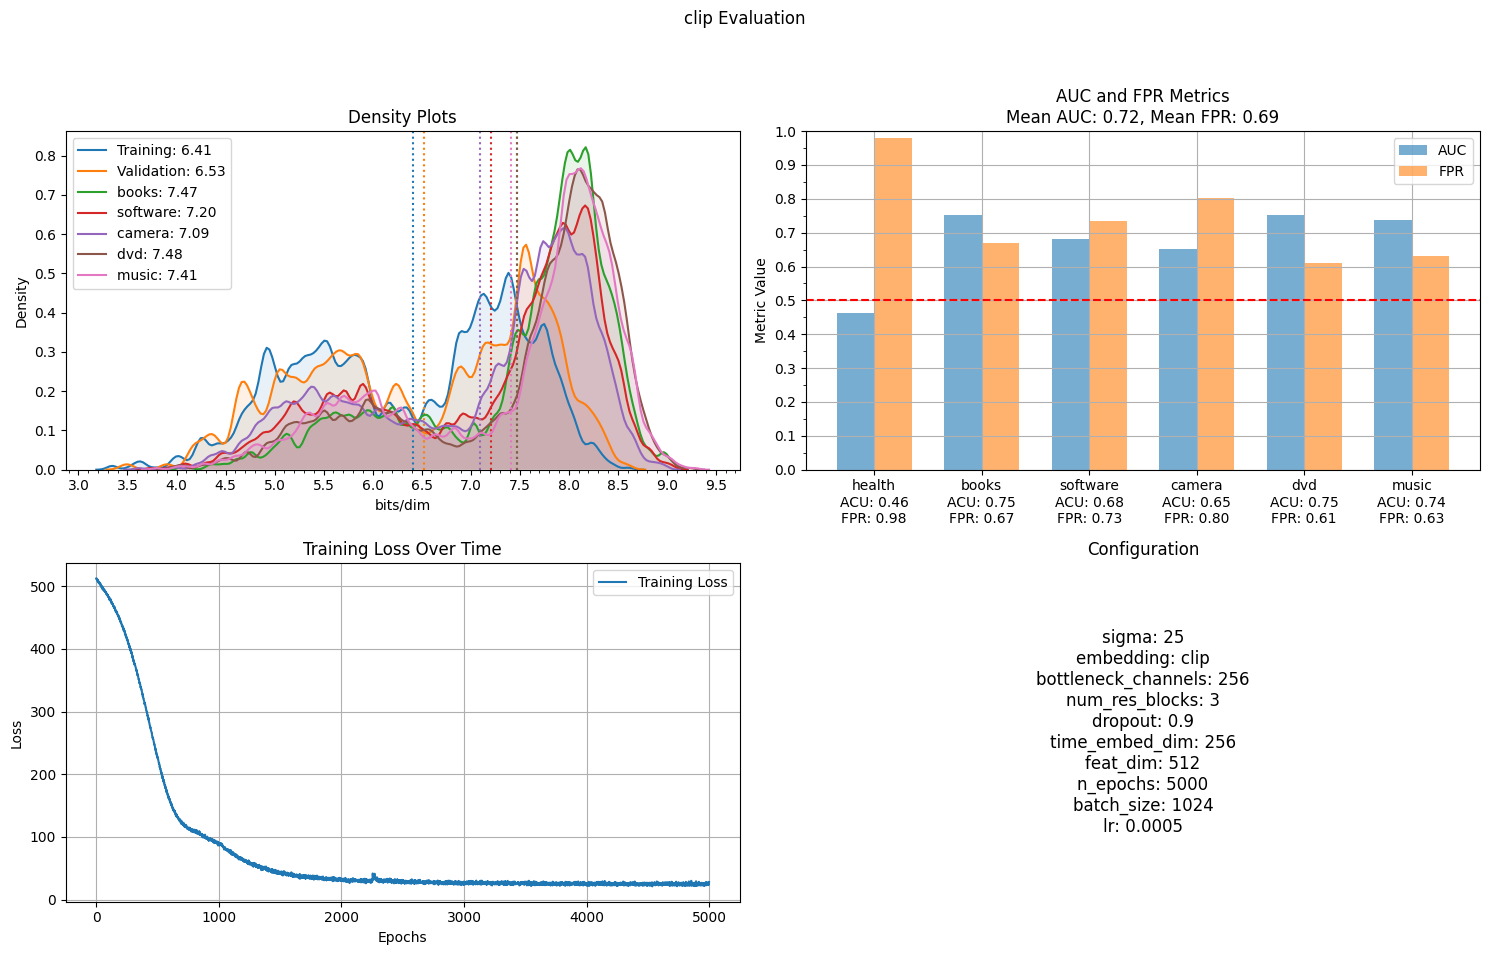

In [316]:
train.plot(eval_data, 
           [e['info']['name'] for e in eval_blobs], 
           train_blob['info']['model'], 
           train_blob['info']['name'], 
           config={
                'sigma':sigma,
                'embedding':embedding,
                'bottleneck_channels':bottleneck_channels,
                'num_res_blocks':num_res_blocks,
                'dropout':dropout,
                'time_embed_dim':time_embed_dim,
                'feat_dim': feat_dim,
                'n_epochs':n_epochs,
                'batch_size':batch_size,
                'lr':lr,
              },
              main_label=main_product
           )



* Yang Song, Jascha Sohl-Dickstein, Diederik P. Kingma, Abhishek Kumar, Stefano Ermon, and Ben Poole. "[Score-Based Generative Modeling through Stochastic Differential Equations.](https://arxiv.org/pdf/2011.13456.pdf)" International Conference on Learning Representations, 2021.
* Jonathan Ho, Ajay Jain, and Pieter Abbeel. "[Denoising diffusion probabilistic models.](https://arxiv.org/pdf/2006.11239.pdf)" Advances in Neural Information Processing Systems. 2020.
*    Yang Song, and Stefano Ermon. "[Improved Techniques for Training Score-Based Generative Models.](https://arxiv.org/pdf/2006.09011.pdf)" Advances in Neural Information Processing Systems. 2020.
*   Yang Song, and Stefano Ermon. "[Generative modeling by estimating gradients of the data distribution.](https://arxiv.org/pdf/1907.05600.pdf)" Advances in Neural Information Processing Systems. 2019.

